# Machine Learning Model Validation

June 21-23, 2023

This demo (based on TaiwanCredit data, a classification task) covers:

- ReLU deep feedforward neural networks (ReLU-DNN) and its interpretation by local linear models.

- A case study based on the CoCircles dataset.

## Install PiML Toolbox

- Run `!pip install piml` to install the latest version of PiML.
- In Google Colab, we need restart the runtime in order to use newly installed version.

In [ ]:
!pip install piml

## Load and Prepare Data

Initilaize a new experiment by `piml.Experiment()`

In [1]:
from piml import Experiment
exp = Experiment()

Choose CoCircles

In [2]:
exp.data_loader()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

In [3]:
exp.data_summary()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

HTML(value='<link rel="stylesheet" href="//stackpath.bootstrapcdn.com/font-awesome/4.7.0/css/font-awesome.min.…

Prepare dataset with default settings

In [4]:
exp.data_prepare()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

## Train Intepretable Models

- Train a ReLU-DNN with default settings.
- Train another ReLU-DNN, and customize it with

    - **Model name**: Sparse-ReLU-DNN
    - **L1_regularization**: 0.00065
    - **Early_stop_epochs**: 100
    - **Batch_size**: 200

- Register ReLU-DNN and Sparse-ReLU-DNN.

In [6]:
exp.model_train()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

## Global Model Interpretation

Choose ReLU-DNN, see the details [here](https://selfexplainml.github.io/PiML-Toolbox/_build/html/guides/models/reludnn.html).

- Switch to the "Global-Interpretability" tab.

- Try the following options to view the different aspects of the model:

    - **Feature**: the univeriate feature for the local linear profile plot.

    - **Feature 1/2**: the bivariate features for the pairwise local liner model plot.

    - **Shown in original scale**: check box can be enabled to display the features in their original scale, instead of the Minmax scaled between 0 to 1.

- The displayed results include:

    - **Feature Importance**: displays the top-10 features' importance.

    - **Parallel Corrodinate Plot**: visualizes coefficients of different local linear models (LLMs), where each line represents a single LLM.

    - **Local Linear Profiles**:

        - 1D: displays the marginal linear functions upon centering.

        - 2D: reveals how the LLM coefficient of one feature would change as another feature value changes.

In [7]:
exp.model_interpret()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

In [8]:
import random
import numpy as np
from random import shuffle
from matplotlib.colors import to_rgba
from matplotlib import pylab as plt

def visualize2D_lines(unp, x, y):

    meshsize = 100
    
    xmin, xmax = np.min(x[:, 0]), np.max(x[:, 0])
    ymin, ymax = np.min(x[:, 1]), np.max(x[:, 1])
    xgrid = np.linspace(xmin, xmax, meshsize)

    fig = plt.figure(figsize=(5, 5))
    for key in range(unp.nllms_top_):
        w1 = unp.all_weights_[key][0]
        w2 = unp.all_weights_[key][1]
        intercept = unp.all_biases_[key]
        if w2 == 0:
            if w1 != 0:
                ygrid = [-1 * intercept / w1] * len(xgrid)
            else:
                continue
        else:
            ygrid = (-1 / w2) * (w1 * xgrid + intercept)
        plt.plot(xgrid, ygrid, color="green", alpha=0.8)

    cmap = plt.get_cmap("bwr")
    plt.scatter(x[:, 0], x[:, 1], s=30, c=y, cmap=cmap)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.show()
    
def visualize2D_regions(unp, x, y):

    meshsize = 100
    xmin, xmax = np.min(x[:, 0]), np.max(x[:, 0])
    ymin, ymax = np.min(x[:, 1]), np.max(x[:, 1])
    xgrid = np.linspace(xmin, xmax, meshsize)
    ygrid = np.linspace(ymin, ymax, meshsize)
    
    grid_input = np.array(np.meshgrid(xgrid, ygrid)).T.reshape(-1, 2)
    confall = unp.get_confs(grid_input)
    data_conf_idx_grid = np.array([unp.conflist_.index(current_conf) if current_conf in unp.conflist_[:unp.nllms_top_] else -1
                         for current_conf in confall.tolist()])
    img = data_conf_idx_grid.reshape(meshsize, meshsize)[:, ::-1].T

    # LLMs
    random.seed(0)
    colorlist = np.arange(len(plt.cm.tab10.colors))
    color_llms = np.zeros((unp.nllms_top_, ), dtype=int)
    colors = np.zeros((img.shape[0], img.shape[1], 4))

    unillms = np.unique(data_conf_idx_grid)
    unillms = unillms[unillms >= 0]
    for idx, confid in enumerate(unillms):
        mask_region = (img == confid)
        edgex1 = (mask_region ^ np.roll(~mask_region, shift=1, axis=0))
        edgey1 = (mask_region ^ np.roll(~mask_region, shift=1, axis=1))
        edgex2 = (mask_region ^ np.roll(~mask_region, shift=-1, axis=0))
        edgey2 = (mask_region ^ np.roll(~mask_region, shift=-1, axis=1))

        nearby_llms = np.unique(np.hstack([img[~edgey1], img[~edgex1], img[~edgey2], img[~edgex2]]))
        nearby_llms = nearby_llms[nearby_llms != -1]
        nearby_llms = nearby_llms[nearby_llms != confid]

        shuffle(colorlist)
        for nc, c in enumerate(colorlist):
            if c not in np.array(color_llms)[nearby_llms]:
                color_llms[idx] = c
                break
            if nc == (len(colorlist) - 1):
                print("Found color conflict. This can be improved by increasing the number of candidate colors in cmap")
        colors[mask_region, :3] = plt.cm.tab10.colors[color_llms[idx]]
    alphas = (img != -1)
    colors[..., -1] = alphas

    # Background
    bgcolors = np.zeros((img.shape[0], img.shape[1], 4))
    bgcolors[img == -1, :3] = to_rgba("grey")[:3]
    bgalphas = (img == -1) * 0.2
    bgcolors[..., -1] = bgalphas

    fig = plt.figure(figsize=(5, 5))
    plt.imshow(colors)
    plt.imshow(bgcolors)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

In [9]:
x, y, _ = exp.get_data(train=True)
unp = exp.get_model("ReLU-DNN").estimator.parse_model()
unp.global_interpret(x, y)

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

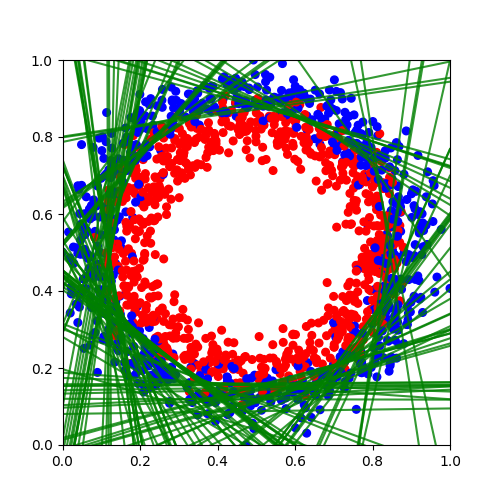

In [10]:
visualize2D_lines(unp, x, y)

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

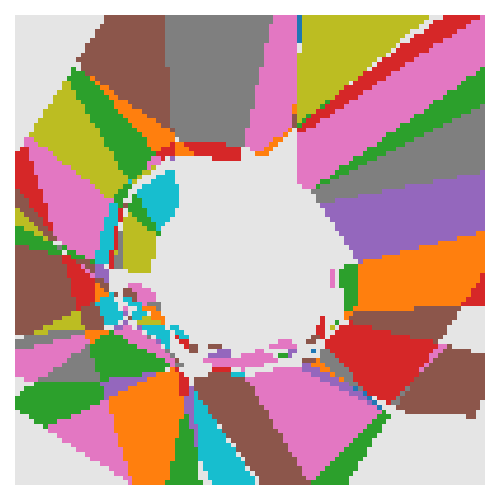

In [11]:
visualize2D_regions(unp, x, y)

Choose Sparse-ReLU-DNN.

In [12]:
exp.model_interpret()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

In [13]:
x, y, _ = exp.get_data(train=True)
unp = exp.get_model("Sparse-ReLU-DNN").estimator.parse_model()
unp.global_interpret(x, y)

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

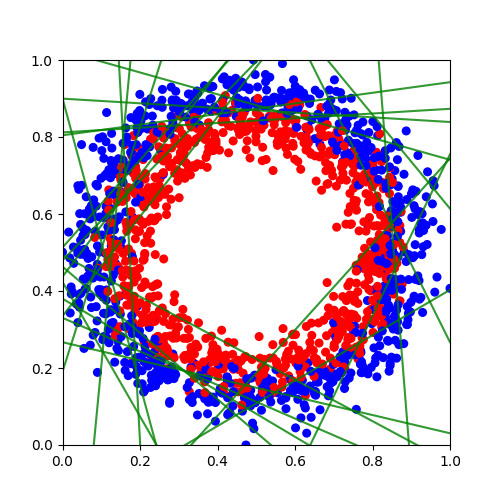

In [14]:
visualize2D_lines(unp, x, y)

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

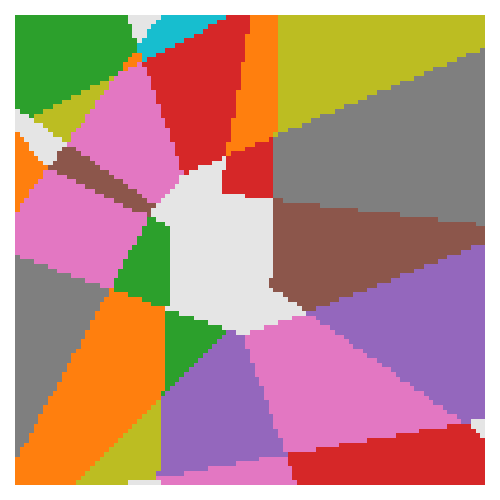

In [15]:
visualize2D_regions(unp, x, y)

## Local Model Interpretation

Choose ReLU-DNN or Sparse-ReLU-DNN.

- Switch to the "Local-Interpretability" tab.

- Try the following options to view the different aspects of the model:

    - **Sample Index**: choose the sample index (in the training set) to be interpreted.

    - **Centered**: whether to display the results by subtracting the mean for each feature.

    - **Shown in original scale**: enable the check box to display the features in their original scale, instead of the Minmax scaled between 0 to 1.

- The displayed results include:

    - **Local Exact Interpretability**: displays the top-10 features' contribution of the sample to be interpreted, see the details [here](https://selfexplainml.github.io/PiML-Toolbox/_build/html/guides/models/reludnn.html#local-interpretation).

In [16]:
exp.model_interpret()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

## LLM Summary Table

Choose ReLU-DNN or Sparse-ReLU-DNN.

- Switch to the "LLM-Summary" tab.

- The displayed results include:

    - **LLM Summary Table**: displays the summary statistics for each LLM, see details [here](https://selfexplainml.github.io/PiML-Toolbox/_build/html/guides/models/reludnn.html#llm-summary-table).

    - **Violin Plot of LLM Coefficients**: shows the LLM coefficient distribution per feature weighted by the sample size of each LLM, see details [here](https://selfexplainml.github.io/PiML-Toolbox/_build/html/guides/models/reludnn.html#llm-summary-table).

In [17]:
exp.model_interpret()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>